# Setup

In [1]:
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

root_path = Path("/home/olivieri/exp").resolve()
src_path = root_path / "src"
sys.path.append(f"{str(src_path)}")

In [2]:
import pandas as pd
from glob import glob
import os

from prompter import *
from data import *

In [4]:
# Setting
BY_MODEL = "LRASPP_MobileNet_V3"
IMAGE_SIZE = (520, 520)
SPLIT_BY = "class-splitted"

In [5]:
root_exp_name = "test_resized"

In [6]:
root_exp_path = get_selected_annots_path(BY_MODEL, SPLIT_BY) / "eval_prs" / root_exp_name

exps_path = glob(f"{root_exp_path}/*")
exps_names = [os.path.splitext(os.path.basename(path))[0] for path in exps_path]
exps_names

['resized']

# Assessment

In [7]:
df_mean_pred_prs = pd.DataFrame()
df_mean_score_prs = pd.DataFrame()
df_mean_pred_prs_per_class = pd.DataFrame()
df_mean_score_prs_per_class = pd.DataFrame()

for exp_path, exp_name in zip(exps_path, exps_names):
    
    variation_paths = glob(f"{exp_path}/*.jsonl")
    variations_names = [os.path.splitext(os.path.basename(path))[0] for path in variation_paths]

    df_pred_prs = pd.DataFrame()
    df_score_prs = pd.DataFrame()
    df_pred_prs_per_class = pd.DataFrame()
    df_score_prs_per_class = pd.DataFrame()

    for variation_name in variations_names:
        eval_prs = get_many_eval_pr(BY_MODEL, SPLIT_BY, f"{root_exp_name}/{exp_name}", variation_name, return_state=False)

        _df_all_prs = pd.DataFrame.from_dict(eval_prs, orient='index')
            
        _df_pred_prs = _df_all_prs.map(lambda x: x["pred"] == "correct" if type(x) == dict else None).mean(axis=1).astype(float)
        _df_score_prs = _df_all_prs.map(lambda x: x["score"] if type(x) == dict else None).mean(axis=1).astype(float)
        _df_pred_prs_per_class = _df_all_prs.map(lambda x: x["pred"] == "correct" if type(x) == dict else None).mean(axis=0).astype(float)
        _df_score_prs_per_class = _df_all_prs.map(lambda x: x["score"] if type(x) == dict else None).mean(axis=0).astype(float)

        _df_pred_prs_per_class.index = _df_pred_prs_per_class.index.map(int)
        _df_score_prs_per_class.index = _df_score_prs_per_class.index.map(int)
        
        df_pred_prs = pd.concat([df_pred_prs, _df_pred_prs], axis=1)
        df_score_prs = pd.concat([df_score_prs, _df_score_prs], axis=1)
        df_pred_prs_per_class = pd.concat([df_pred_prs_per_class, _df_pred_prs_per_class], axis=1)
        df_score_prs_per_class = pd.concat([df_score_prs_per_class, _df_score_prs_per_class], axis=1)

    df_pred_prs.columns = variations_names
    df_score_prs.columns = variations_names
    df_pred_prs_per_class.columns = variations_names
    df_score_prs_per_class.columns = variations_names

    df_mean_pred_prs = pd.concat([df_mean_pred_prs, df_pred_prs.mean(axis=0)], axis=1)
    df_mean_score_prs = pd.concat([df_mean_score_prs, df_score_prs.mean(axis=0)], axis=1)
    df_mean_pred_prs_per_class = pd.concat([df_mean_pred_prs_per_class, df_pred_prs_per_class.mean(axis=1)], axis=1)
    df_mean_score_prs_per_class = pd.concat([df_mean_score_prs_per_class, df_score_prs_per_class.mean(axis=1)], axis=1)

df_mean_pred_prs.columns = exps_names
df_mean_score_prs.columns = exps_names
df_mean_pred_prs_per_class.columns = exps_names
df_mean_score_prs_per_class.columns = exps_names

## Pred

,mean,std,min,max
ArrayMasks_Imgs_Ovr,0.737500,0.409388,0.0,1.0
ArrayMasks_Imgs,0.662500,0.369205,0.0,1.0
ArrayMasks,0.533333,0.444591,0.0,1.0
ConcatMasks_NoSc_Hz,0.716667,0.419203,0.0,1.0
ConcatMasks_NoSc_Vr,0.675000,0.437547,0.0,1.0
ConcatMasks_Ovr_Hz,0.775000,0.379577,0.0,1.0
ConcatMasks_Ovr_Vr,0.712500,0.407778,0.0,1.0
ConcatMasks_Sc_Hz,0.750000,0.413585,0.0,1.0
ConcatMasks_Sc_Vr,0.679167,0.410280,0.0,1.0
SepMasks_NoSc,0.729167,0.347164,0.0,1.0


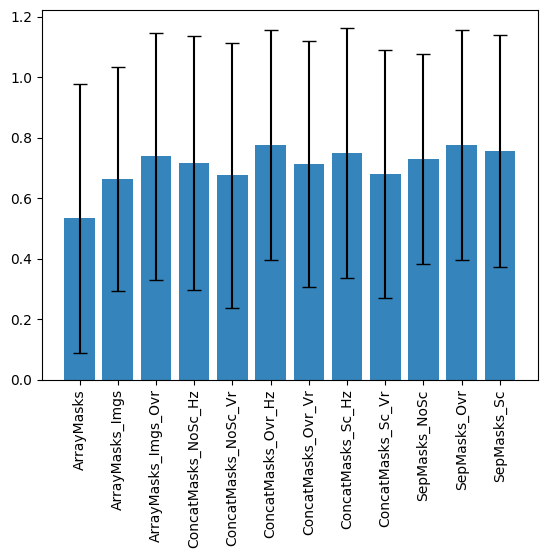

In [8]:
display(df_pred_prs.describe().sort_index().transpose()[["mean", "std", "min", "max"]])
mean = df_pred_prs.transpose().sort_index().mean(axis=1)
std = df_pred_prs.transpose().sort_index().std(axis=1)
plt.bar(mean.index, mean, yerr=std, capsize=5, alpha=0.9)
plt.ylim(bottom=0)
plt.xticks(rotation=90)
plt.show()

## Score

In [9]:
display(df_score_prs.describe().sort_index().transpose()[["mean", "std", "min", "max"]])

,mean,std,min,max
ArrayMasks_Imgs_Ovr,3.508333,1.111444,1.333333,5.0
ArrayMasks_Imgs,3.333333,1.027402,1.666667,5.0
ArrayMasks,2.958333,1.090730,1.000000,5.0
ConcatMasks_NoSc_Hz,3.325000,1.150229,1.000000,4.5
ConcatMasks_NoSc_Vr,3.550000,1.116202,1.333333,5.0
ConcatMasks_Ovr_Hz,3.575000,1.060281,1.333333,5.0
ConcatMasks_Ovr_Vr,3.245833,1.058755,1.000000,4.0
ConcatMasks_Sc_Hz,3.666667,1.048530,1.333333,5.0
ConcatMasks_Sc_Vr,3.308333,1.079142,1.666667,5.0
SepMasks_NoSc,3.625000,0.985086,2.000000,5.0


In [10]:
df_mean_score_prs.describe().iloc[[1, 2, 3, 7]]

,resized
mean,3.429514
std,0.202863
min,2.958333
max,3.666667


## Per-Class

In [11]:
sign_classes_np = np.zeros((max(df_pred_prs.index)+1, max(df_pred_prs_per_class.index)+1))
sign_classes_np.shape

for img_idx in sorted(df_pred_prs.index):
    significant_classes_gt = get_significant_classes(GTS_PATH / (image_UIDs[img_idx] + ".png"), IMAGE_SIZE, CLASS_MAP)
    for c in significant_classes_gt:
        sign_classes_np[img_idx, c] += 1
class_counts = np.sum(sign_classes_np, axis=0)

In [12]:
df_pred_prs_per_class.index.name = "img_idx"
df_pred_prs_per_class['counts'] = [class_counts[c] for c in df_pred_prs_per_class.index]
df_pred_prs_per_class = df_pred_prs_per_class.sort_values(by=['counts', "img_idx"]).drop(columns='counts')

,mean,std,min,max
img_idx,,,,
18,1.000000,0.000000,1.000000,1.000000
2,0.500000,0.000000,0.500000,0.500000
9,0.708333,0.334279,0.000000,1.000000
11,0.750000,0.452267,0.000000,1.000000
12,1.000000,0.000000,1.000000,1.000000
14,0.333333,0.492366,0.000000,1.000000
17,0.333333,0.492366,0.000000,1.000000
3,0.875000,0.310791,0.000000,1.000000
4,0.791667,0.334279,0.000000,1.000000


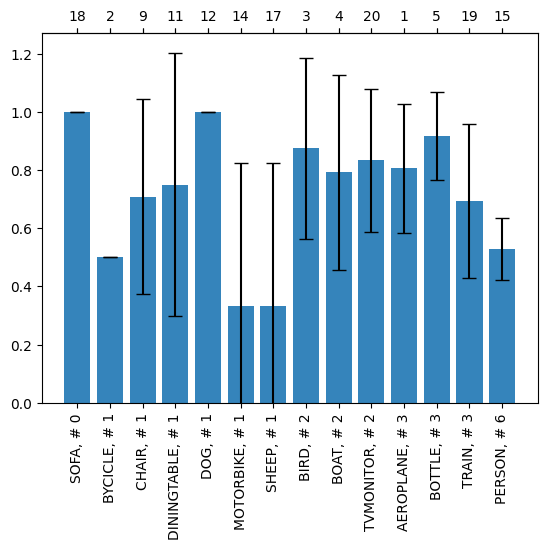

In [13]:
display(df_pred_prs_per_class.transpose().describe().transpose()[["mean", "std", "min", "max"]])
mean = df_pred_prs_per_class.transpose().mean()
std = df_pred_prs_per_class.transpose().std()
plt.bar([f"{CLASSES[i]}, # {int(class_counts[i])}" for i in mean.index], mean, yerr=std, capsize=5, alpha=0.9)
plt.tick_params(axis='x', which='both', top=True)
top_ax = plt.gca().secondary_xaxis('top')
top_ax.set_xticks(range(len(mean.index)))
top_ax.set_xticklabels(mean.index)
plt.ylim(bottom=0)
plt.xticks(rotation=90)
plt.show()